In [1]:
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

In [3]:
import pandas as pd
import numpy as np

#Подготовка Данных

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML 4 course/nsu_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML 4 course/nsu_test.csv')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25062 entries, 0 to 25061
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              25062 non-null  object 
 1   Category          25062 non-null  object 
 2   Brand             25061 non-null  object 
 3   Seller            25031 non-null  object 
 4   Color             127 non-null    object 
 5   Comments          25062 non-null  float64
 6   Final price       25062 non-null  float64
 7   Max price         25062 non-null  float64
 8   Min price         25062 non-null  float64
 9   Average price     19264 non-null  float64
 10  Sales             25062 non-null  float64
 11  Days in stock     25062 non-null  float64
 12  Days with sales   25062 non-null  int64  
 13  Rating            25062 non-null  object 
 14  Basic Sale        25062 non-null  float64
 15  Basic Sale Price  25062 non-null  float64
 16  Base price        25062 non-null  float6

Добавим среднюю цену среди категории

In [6]:
avg_price_per_category = []
for cat in np.unique(train_data['Category'].values):
    # print(cat)
    avg_price_per_category.append(train_data[train_data['Category'] == cat]['Average price'].mean())
    cat_mean_price = train_data[train_data['Category'] == cat]['Average price'].mean()
    train_data.loc[train_data['Category'] == cat, 'Avg_price_per_category'] = cat_mean_price
# print(avg_price_per_category)
# train_data.head()

avg_price_per_category = []
for cat in np.unique(test_data['Category'].values):
    # print(cat)
    avg_price_per_category.append(test_data[test_data['Category'] == cat]['Average price'].mean())
    cat_mean_price = test_data[test_data['Category'] == cat]['Average price'].mean()
    test_data.loc[test_data['Category'] == cat, 'Avg_price_per_category'] = cat_mean_price

Добавим фичу, если средняя цена продажи не выше чем средняя цена по сегменту - 1, иначе 0




In [7]:
train_data['avg_price_not_more_than_evg_cat'] = np.where((train_data['Avg_price_per_category'] >= train_data['Average price']), 1, 0)
train_data['avg_price_not_more_than_evg_cat'] = train_data['avg_price_not_more_than_evg_cat'].astype('object')

test_data['avg_price_not_more_than_evg_cat'] = np.where((test_data['Avg_price_per_category'] >= test_data['Average price']), 1, 0)
test_data['avg_price_not_more_than_evg_cat'] = test_data['avg_price_not_more_than_evg_cat'].astype('object')

ratings = train_data['Rating'].values
num_ratings = [int(rating.split(',')[0]) for rating in ratings]
train_data['Rating'] = num_ratings

ratings = test_data['Rating'].values
num_ratings = [int(rating.split(',')[0]) for rating in ratings]
test_data['Rating'] = num_ratings

In [8]:
# print(f"mean: {train_data['Comments'][:len(train_data['Comments'].values)].mean()}")
print(f"mean: {train_data.sort_values(by='Comments').loc[:len(train_data.sort_values(by='Comments')['Comments'].values)-1, 'Comments'].mean()}")

# train_data.sort_values(by='Comments').loc[:len(train_data.sort_values(by='Comments')['Comments'].values)-1, 'Comments'].value_counts()

mean: 4.590824942430126


In [9]:
train_data['comments_more_than_avg'] = (train_data['Comments'] > 5).astype('object')
# pd.crosstab(train_data['comments_more_than_avg'], train_data['Sales'], margins=True)
test_data['comments_more_than_avg'] = (test_data['Comments'] > 5).astype('object')

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
def deleteId(ds):
    return ds.drop(columns='Id')

def deleteNaN(train_ds, test_ds, critval):
    fullsize = train_ds.shape[0]
    new_train = train_ds.copy()
    new_test = test_ds.copy()
    for feature in new_train.columns:
        nulls = new_train[feature].isnull().sum()
        percent = nulls / fullsize
        # если доля пустых значений превышает critval - столбец не информативен,
        # можно его выбросить
        if (percent > critval):
            new_train = new_train.drop(columns=feature)
            new_test = new_test.drop(columns=feature)
    return new_train, new_test

def convertToNumeric(train_ds, test_ds):
    new_train = train_ds.copy()
    new_test = test_ds.copy()
    LE = LabelEncoder()
    for feature in new_train.columns:
        if (new_train[feature].dtype == 'object'):
            new_train[feature] = LE.fit_transform(new_train[feature])
            new_test[feature] = LE.fit_transform(new_test[feature])
    return new_train, new_test

In [12]:
train = train_data.drop_duplicates()

# train = train.drop(columns='Id')
train = train.drop(columns='Color')
train = train.drop(columns='Base price')
train = train.drop(columns='Basic Sale Price')

test = test_data.drop(columns='Id')
test = test.drop(columns='Color')
test = test.drop(columns='Base price')
test = test.drop(columns='Basic Sale Price')

train, test = deleteNaN(train, test, critval=0.8)
train, test = convertToNumeric(train, test)

train_y = train['Sales'].values
train_X = train.drop(columns='Sales').values
val_test = test.values

train_x, test_x, train_y, test_y = train_test_split(train_X, train_y, test_size=0.1, random_state=7)  # random_state=98987)

#Избавимся от NaN значений


In [13]:
strategies = ['mean', 'median', 'most_frequent']
imputer = SimpleImputer(strategy=strategies[1])
trainX = imputer.fit_transform(train_x)
testX = imputer.fit_transform(test_x)
val_test_x = imputer.fit_transform(val_test)

In [14]:
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)
val_test_x = scaler.transform(val_test_x)

#Метрика **SMAPE**

In [18]:
def smape(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F))
    tmp[np.isnan(tmp)] = 0
    return np.sum(tmp) / len(tmp) * 100

In [19]:
def check_error(preds, gt):
    print('SMAPE Error:', smape(np.round(preds), gt))
    # print('RMSE Error:', mean_squared_error(np.round((np.abs(preds))), gt, squared=False))

#Модель комбинированная

###Подготовим алгоритм кластеризации

In [30]:
classes = 3

model = KMeans(n_clusters=classes)
model.fit(trainX)

train_predictions = model.predict(trainX)
test_predictions = model.predict(testX)


In [31]:
trainX0, trainY0 = trainX[np.where(train_predictions==0)], train_y[np.where(train_predictions==0)]
testX0, testY0 = testX[np.where(test_predictions==0)], test_y[np.where(test_predictions==0)]

trainX1, trainY1 = trainX[np.where(train_predictions==1)], train_y[np.where(train_predictions==1)]
testX1, testY1 = testX[np.where(test_predictions==1)], test_y[np.where(test_predictions==1)]

trainX2, trainY2 = trainX[np.where(train_predictions==2)], train_y[np.where(train_predictions==2)]
testX2, testY2 = testX[np.where(test_predictions==2)], test_y[np.where(test_predictions==2)]

In [38]:
last_rf_best_params = {
    'criterion': 'absolute_error', 
    'max_depth': 300,  # 300
    'n_estimators': 70, # 70
    'min_samples_leaf': 5, # 3
    'min_samples_split': 3 # 50
}

# random_forest = RandomForestRegressor(**rf_gs_model.best_params_)
rf0 = RandomForestRegressor(**last_rf_best_params) 
rf0.fit(trainX0, trainY0)
check_error(rf0.predict(testX0), testY0)

SMAPE Error: 16.981298659032195


In [49]:
last_rf_best_params = {
    'criterion': 'absolute_error', 
    'max_depth': 1000,  # 300
    'n_estimators': 40, # 70
    'min_samples_leaf': 5, # 5
    'min_samples_split': 3 # 3
}

# 300, 70, 5, 3 - 34.8
# 500, 50, 5, 3 - 34.58
# random_forest = RandomForestRegressor(**rf_gs_model.best_params_)
rf1 = RandomForestRegressor(**last_rf_best_params) 
rf1.fit(trainX1, trainY1)
check_error(rf1.predict(testX1), testY1)

SMAPE Error: 34.67747245404751


In [36]:
last_rf_best_params = {
    'criterion': 'absolute_error', 
    'max_depth': 300,  # 300
    'n_estimators': 70, # 70
    'min_samples_leaf': 5, # 3
    'min_samples_split': 3 # 50
}

# random_forest = RandomForestRegressor(**rf_gs_model.best_params_)
rf2 = RandomForestRegressor(**last_rf_best_params) 
rf2.fit(trainX2, trainY2)
check_error(rf2.predict(testX2), testY2)

SMAPE Error: 13.1758048018375


In [43]:
def Predict(samples):
    prediction = []
    for sample in samples:
        claster = model.predict([sample])
        if claster == 0:
            prediction.append(np.round(rf0.predict([sample])))
        elif claster == 1:
            prediction.append(np.round(rf1.predict([sample])))
        elif claster == 2:
            prediction.append(np.round(rf2.predict([sample])))
    return np.array(prediction)

#Соревы

In [39]:
submission_path = '/content/drive/MyDrive/Colab Notebooks/ML 4 course/nsu_sample_solution.csv'
submission = pd.read_csv(submission_path)

In [ ]:
predictions0 = np.round(rf0.predict(val_test_x))
predictions1 = np.round(rf11.predict(val_test_x))
predictions2 = np.round(xgb_reg.predict(val_test_x))
# predictions0.shape
val_samples = val_test_x
val_samples = np.insert(val_samples, 0, predictions0, axis=1)
val_samples = np.insert(val_samples, 0, predictions1, axis=1)
val_samples = np.insert(val_samples, 0, predictions2, axis=1)
val_samples.shape
scaler = StandardScaler()
val_samples = scaler.fit_transform(val_samples)

predictions = np.round(random_forest.predict(val_samples))
submission['Expected'] = predictions
submission
submission.to_csv('submission_rf.csv', index=False)

In [44]:
predictions = Predict(val_test_x)
submission['Expected'] = predictions
submission
submission.to_csv('submission_meta.csv', index=False)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


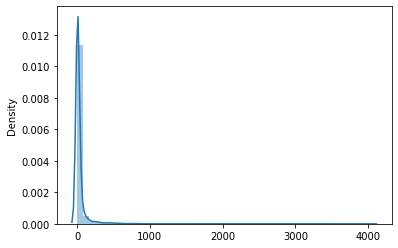

In [45]:
sns.distplot(predictions)

In [ ]:
predictions = np.round(xgb_reg.predict(val_test_x))
submission['Expected'] = predictions
submission
submission.to_csv('submission_xgboost.csv', index=False)